# 9. 프로젝트 : 폐렴 진단기 성능개선


## 1. set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세용
BATCH_SIZE = 16
EPOCHS = 14

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames)) # 5216개
print(len(test_filenames))  # 624개
print(len(val_filenames))   # 165ㅐ

5216
624
16


비율이 89, 10.7, 0.3이라서 val 이 너무 부족함 더 가져오자

train + val 해서 8:2로 분할

In [4]:
# train + val을 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다
train_size = math.floor(len(filenames)*0.8) #수정하면 개수가 달라질 수 있음
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames)) # 4185개
print(len(val_filenames))   # 1047개

4185
1047


train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인해보자

In [5]:
# 파일 경로 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
# 파일 경로에 NORMAL/PNEUMONIA 있는지 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 결과를 보면 정상보다 폐렴 이미지가 3배 더 많음
- 우리가 사용할 CNN모델의 경우 데이터 클래스별 밸런스가 좋을수록 훈련이 잘 된다
- 클래스 불균형은 나중에 조정할 예정
- test, val데이터셋은 학습과 관련이 없으므로 불균형해도 괜찮다

In [7]:
# tf.data 인스턴스를 만들자 -> tensorflow 학습 시 mini-batch로 작업 가능
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없다
- 파일 경로 normal/pneumonia로 라벨 데이터를 만들어주는 함수를 만들자

In [9]:
# 파일 경로의 끝에서 두번째 부분 확인 -> 양성과 음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(true), 노말이면 음성(false)

- 이미지 데이터는 현실적으로 사이즈가 제각각
- 이미지 사이즈를 통일하고 gpu메모리를 효율적으로 쓰기 위해 이미지 사이즈 조정
- decode_img/process_path 함수를 만들자
- process_path에서 decode_img 함수를 이용해서 이미지 데이터 타입을 float으로 바꾸고 사이즈 변경
- get_label을 이용해서 라벨 값을 가져온다

In [10]:
# 이미지 형식 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 unit8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 image_size로 수정
    return img
    
# 이미지 파일의 경로를 입력하면 이미지와 라벨 읽어온다
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train/validation 데이터셋 만들기, num_parallel_calls 파라미터에 위에서 할당한 Autotune 변수를 이용하면 빠르게 처리 가능
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 리사이즈, 라벨 잘 됐는지 확인
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다는 뜻
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


텐서플로우에서는 tf.data 파이프라인을 사용해서 학습데이터를 효율적으로 사용할 수 있도록 한다. 
- tf.data파이프라인을 이용해 prepare_for_training()함수를 정의해서 데이터를 변환시켜주자
- shuffle()을 사용해 고정크기버퍼 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat()을 사용해 epoch를 진행하면서 데이터셋을 불러올 때 여러번 사용할 수 있게 해주자
- batch()로 배치사이즈에서 정한 만큼의 배치를 사용
- prefetch()를 쓰면 학습 데이터를 나눠서 읽어온다. 첫번째 데이터를 gpu에서 학습하는 동안 두번째 데이터를 cpu에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다

In [14]:
# 좌우반전 augmentation 도입
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
- 데이터를 보기 위해 먼저 train에 있는 batch중 첫번째 배치 추출
- 추출된 배치를 image와 label데이터 셋으로 나눈다
- show_batch()함수를 이용해 결과 사진을 보자

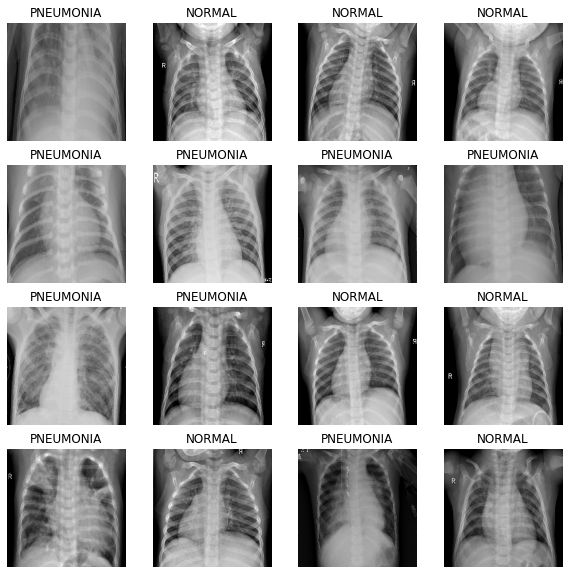

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여준다
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링
: 이미지 처리에 특화된 딥러닝 모델

- convolution block 만들기
- conv_block() 구성은 convolution 2번 진행 + batch normalization을 통해 Gradient vanishing, Gradient Exploding 해결, max pooling

In [16]:
# convolution block 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# dense block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
- 한 라벨이 너무 많은 경우 Weight balancing 사용
- training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
- keras는 model.fit()호출 시 class_weight에 가중치를 세팅할 수 있도록 지원한다

In [19]:
# 각각 가중치 세팅, 데이터 전체 건수에 반비례하도록 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0       # normal 이미지 가중치 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0    # pneumonia 이미지 가중치 세팅

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):    # GPU 선택
    model = build_model()    # 만들었던 모델 함수 build_model() 선언

    METRICS = [                  # 성과 측정 metrics로는 accuracy, precision, recall 사용
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',              
        loss='binary_crossentropy',    # 이미지 라벨이 두개라서 binary crossentropy loss 사용
        metrics=METRICS
    )

In [21]:
# 모델 fit - 20분 이상 소요
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/14
261/261 [==============================] - 62s 191ms/step - loss: 0.4099 - accuracy: 0.7926 - precision: 0.9469 - recall: 0.7641 - val_loss: 0.6182 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/14
261/261 [==============================] - 50s 191ms/step - loss: 0.2342 - accuracy: 0.9080 - precision: 0.9719 - recall: 0.9025 - val_loss: 1.1770 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/14
261/261 [==============================] - 50s 192ms/step - loss: 0.2012 - accuracy: 0.9236 - precision: 0.9754 - recall: 0.9204 - val_loss: 0.1402 - val_accuracy: 0.9394 - val_precision: 0.9291 - val_recall: 0.9935
Epoch 4/14
261/261 [==============================] - 50s 190ms/step - loss: 0.1784 - accuracy: 0.9356 - precision: 0.9814 - recall: 0.9312 - val_loss: 0.1224 - val_accuracy: 0.9471 - val_precision: 0.9350 - val_recall: 0.9974
Epoch 5/14
261/261 [==============================] - 51s 197ms/step - loss: 0.1807 - accura

## 7. 결과 확인과 시각화

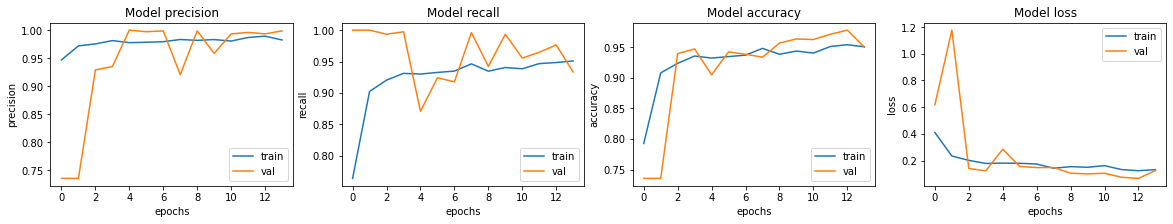

In [22]:
# 그래프로 각 epochs마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 테스트 데이터로 모델 평가, loss, accuracy, precision, recall 값 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.4123 - accuracy: 0.8798 - precision: 0.8777 - recall: 0.9385
Loss: 0.41229012608528137,
Accuracy: 0.879807710647583,
Precision: 0.8776978254318237,
Recall: 0.9384615421295166
